### To Do:
- Fix asset mix / performance to match original 1/N paper
- Benchmark performance against using only correlationmatrix for features
- Try on S&P? More data

### Done
- Day forward chaining for cross validation
- Weight the loss by the std dev of the sharpe ratios
- Measure performance of model strategy by sharpe ratio
- ROC curves

## Import PyTorch etc.

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data as torchdata

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import Embedding and Performance Data

In [232]:
performance = pd.read_csv('~/Documents/RiskLab/Asset Allocation Strategies/FinEmbed/Data/US_set_optimal_strategy.csv')
#performance = pd.read_csv('~/Documents/RiskLab/Asset Allocation Strategies/FinEmbed/Data/US_set_optimal_strategy2.csv')
feature = pd.read_csv('~/Documents/RiskLab/Asset Allocation Strategies/FinEmbed/Data/NNdata.csv')
feature.drop(columns='Unnamed: 0',inplace=True)
#performance.rename(columns={'Unnamed: 0':'Start Date'},inplace=True)
#performance['MinVar Sharpe'] = 0.5*performance['MinVar Sharpe']

def to_year_month(s):
    s = str(s)
    return s[:7]

# performance['Start Date'] = performance['Unnamed: 0']
# performance.drop(columns='Unnamed: 0',inplace=True)
performance['Start Date'] = performance['Start Date'].apply(to_year_month)
performance.rename(columns={'Sharpe 1/N': '1/N Sharpe', 'Sharpe ERC': 'ERC Sharpe', 'Sharpe MinVar': 'MinVar Sharpe'},inplace=True)

feature = feature.T
feature['Start Date'] = feature.index
feature['Start Date'] = feature['Start Date'].apply(to_year_month)
feature.reset_index(inplace=True,drop=True)
feature.head()

data = pd.merge(feature,performance,how='inner',on='Start Date')
df = data
data = data.values

test_proportion = 0.2
test_data = data[int(data.shape[0]*(1 - test_proportion)) + 2:,:]
data = data[:int(data.shape[0]*(1 - test_proportion)),:]

In [233]:
performance[['1/N Sharpe','ERC Sharpe', 'MinVar Sharpe']].mean()

1/N Sharpe       0.914930
ERC Sharpe       1.511406
MinVar Sharpe    0.439224
dtype: float64

## Initialize Hyper-parameters

In [237]:
input_size = 5593  
hidden_size_1 = 500
hidden_size_2 = 100
num_classes = 3
num_epochs = 250
batch_size = 5
learning_rate = 0.001

## Feedforward Neural Network Model Structure

In [235]:
class Net(nn.Module):
    
    def __init__(self,input_size,hidden_size_1,hidden_size_2,num_classes):
      
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(input_size,hidden_size_1)
        self.linear2 = torch.nn.Linear(hidden_size_1,hidden_size_2)
        self.linear3 = torch.nn.Linear(hidden_size_2,num_classes)
        
        
    def forward(self, x):
   
        h1 = F.relu(self.linear1(x)) 
        h2 = F.relu(self.linear2(h1))
        D = nn.Dropout(0.5)
        #y_pred = self.linear3(D(h2))
        y_pred = self.linear3(h2)
        
        return y_pred
    

## Instantiate the FNN

In [238]:
net = Net(input_size, hidden_size_1, hidden_size_2, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

## Train. Day forward chaining

In [239]:
feature_indicies = [0,5593]
label_index = 5594

num_obs = data.shape[0]
n_links = 10
link_size = int(num_obs / 5)

train_loss_list, valid_loss_list = [],[]

for epoch in range(1,num_epochs+1):
    
    train_loss, val_loss = [], []

    for link in range(1,n_links+1):

        # Partition Data
        X_train = data[:link*link_size,feature_indicies[0]:feature_indicies[1]].astype(np.float64)
        Y_train = data[:link*link_size,label_index].astype(np.float64)
        X_val   = data[((link*link_size) + 2):(link+1)*link_size,feature_indicies[0]:feature_indicies[1]].astype(np.float64)
        Y_val   = data[((link*link_size) + 2):(link+1)*link_size,label_index].astype(np.float64)

        # Convert to tensor
        X_train_tensor = torch.Tensor(X_train)
        Y_train_tensor = torch.Tensor(Y_train)
        X_val_tensor   = torch.Tensor(X_val)
        Y_val_tensor   = torch.Tensor(Y_val)

        # Create loader objects
        train_data   = torchdata.TensorDataset(X_train_tensor,Y_train_tensor)
        train_loader = torchdata.DataLoader(train_data,batch_size=batch_size,shuffle=False)
        val_data     = torchdata.TensorDataset(X_val_tensor,Y_val_tensor)
        val_loader   = torchdata.DataLoader(val_data,batch_size=batch_size,shuffle=False)


        # Train weights
        net.train()
        for i, (months, labels) in enumerate(train_loader):   # Load a batch of images with its (index, data, class)
            months = Variable(months)         
            labels = Variable(labels.long())
            optimizer.zero_grad()                             # Intialize the hidden weight to all zeros
            outputs = net(months)                             # Forward pass: compute the output class given a image
            loss = criterion(outputs, labels)                 # Compute the loss: difference between the output class and the pre-given label
            loss.backward()                                   # Backward pass: compute the weight
            optimizer.step()                                  # Optimizer: update the weights of hidden nodes
            train_loss.append(loss.item())


        # Validation    
        net.eval()
        for i, (months, labels) in enumerate(val_loader):
            months = Variable(months)
            labels = Variable(labels.long())
            outputs = net(months)
            loss = criterion(outputs, labels)
            val_loss.append(loss.item())


            
    train_loss_list.append(np.mean(train_loss))
    valid_loss_list.append(np.mean(val_loss))
    
    

KeyboardInterrupt: 

## Train. Day forward chaining with sharpe weights

In [ ]:
feature_indices = np.arange(5593)
sharpe_indices  = np.array([5596,5597,5598])
label_index     = 5594

num_obs = data.shape[0]
n_links = 10
link_size = int(num_obs / 5)

train_loss_list, valid_loss_list = [],[]

for epoch in range(1,num_epochs+1):
    
    train_loss, val_loss = [], []

    for link in range(1,n_links+1):

        # Partition Data
        X_train = np.take(data[:link*link_size,:],feature_indices,axis=1).astype(np.float64)
        Y_train = data[:link*link_size,label_index].astype(np.float64)
        X_val   = np.take(data[((link*link_size) + 2):(link+1)*link_size,:],feature_indices,axis=1).astype(np.float64)
        Y_val   = data[((link*link_size) + 2):(link+1)*link_size,label_index].astype(np.float64)

        sharpe_train  = np.take(data[:link*link_size,:],sharpe_indices,axis=1).astype(np.float64)
        sharpe_val    = np.take(data[((link*link_size) + 2):(link+1)*link_size,:],sharpe_indices,axis=1).astype(np.float64)

        
        # Convert to tensor
        X_train_tensor = torch.Tensor(X_train)
        Y_train_tensor = torch.Tensor(Y_train)
        X_val_tensor   = torch.Tensor(X_val)
        Y_val_tensor   = torch.Tensor(Y_val)
        
        sharpe_train_tensor = torch.Tensor(sharpe_train)
        sharpe_val_tensor   = torch.Tensor(sharpe_val)
        

        # Create loader objects
        train_data    = torchdata.TensorDataset(X_train_tensor,Y_train_tensor,sharpe_train_tensor)
        train_loader  = torchdata.DataLoader(train_data,batch_size=batch_size,shuffle=False)
        val_data      = torchdata.TensorDataset(X_val_tensor,Y_val_tensor,sharpe_val_tensor)
        val_loader    = torchdata.DataLoader(val_data,batch_size=batch_size,shuffle=False)
        
        #sharpe_loader = torchdata.DataLoader(sharpe_tensor,batch_size=batch_size,shuffle=False)


        # Train weights
        net.train()
        for i, (months, labels, ratios) in enumerate(train_loader):   # Load a batch of images with its (index, data, class)
            
            months, labels, ratios = Variable(months), Variable(labels.long()), Variable(ratios)         
            
            optimizer.zero_grad()                             # Intialize the hidden weight to all zeros
            outputs = net(months)                             # Forward pass: compute the output class given a image
            
            loss = criterion(outputs,labels)
            weight = np.std(ratios.data.numpy())
            loss = loss*weight
            loss.backward()                                   # Backward pass: compute the weight
            
            optimizer.step()                                  # Optimizer: update the weights of hidden nodes
            train_loss.append(loss.item())
            
            
        # Validation    
        net.eval()
        for i, (months, labels, ratios) in enumerate(val_loader):
            months, labels, ratios = Variable(months), Variable(labels.long()), Variable(ratios)

            outputs = net(months)
            loss = criterion(outputs, labels)
            weight = np.std(ratios.data.numpy())
            loss = loss*weight
            val_loss.append(loss.item())


            
    train_loss_list.append(np.mean(train_loss))
    valid_loss_list.append(np.mean(val_loss))
    

## Performance

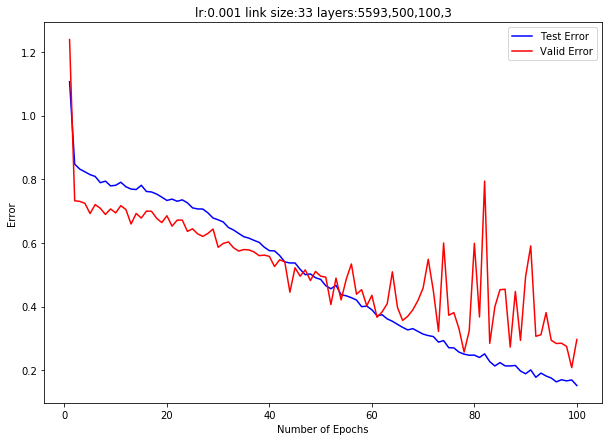

In [207]:
############################Plot of Testing Error and Validation Error#################

fig, ax = plt.subplots(1,1,figsize = (10, 7))
ax.set_title('Testing Error'+'  '+'Validation Error')
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Error')
x = range(1,num_epochs+1)

plt.plot(x,train_loss_list,c = 'b',label = 'Test Error')
plt.plot(x, valid_loss_list,c = 'r',label = 'Valid Error')
plt.title('lr:'+str(learning_rate)+' '+'link size:'+str(link_size)+' '+'layers:'
          +str(input_size)+','+str(hidden_size_1)+','+str(hidden_size_2)+','+str(num_classes))
ax.legend()


In [208]:
X_test = np.take(test_data,feature_indices,axis=1).astype(np.float64)
Y_test = test_data[:,label_index].astype(np.float64)

X_test_tensor = torch.Tensor(X_test)
Y_test_tensor = torch.Tensor(Y_test)

test_data_tensor = torchdata.TensorDataset(X_test_tensor,Y_test_tensor)
test_loader = torchdata.DataLoader(test_data_tensor,batch_size=batch_size,shuffle=False)

correct = 0
total = 0

for months, labels in test_loader:
    labels = labels.long()
    months = Variable(months)
    outputs = net(months)
    _, predicted = torch.max(outputs.data, 1)  # Choose the best class from the output: The class with the best score
    total += labels.size(0)                    # Increment the total count
    correct += (predicted == labels).sum()     # Increment the correct count
    
print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 65 %


In [209]:
feature_test_tensor = torch.from_numpy(X_test) 
feature_test_tensor = feature_test_tensor.float()

test_pred = net(feature_test_tensor).detach().numpy()

p = np.take(test_data,sharpe_indices,axis=1)

model_strategy   = np.argmax(test_pred,axis=1)[:,None]
optimal_strategy = np.argmax(p,axis=1)[:,None]
naive_strategy   = np.full(p.shape[0],0)[:,None]
erc_strategy     = np.full(p.shape[0],1)[:,None]
minvar_strategy  = np.full(p.shape[0],2)[:,None]

model_sharpe   = np.take_along_axis(p,model_strategy,axis=1).mean()
optimal_sharpe = np.take_along_axis(p,optimal_strategy,axis=1).mean()
naive_sharpe   = np.take_along_axis(p,naive_strategy,axis=1).mean()
erc_sharpe     = np.take_along_axis(p,erc_strategy,axis=1).mean()
minvar_sharpe  = np.take_along_axis(p,minvar_strategy,axis=1).mean()

print('optimal sharpe: ',round(optimal_sharpe,3))
print('model sharpe:   ',round(model_sharpe,3))
print('average sharpe: ',round((naive_sharpe + erc_sharpe + minvar_sharpe) / 3,3))
print('')
print('naive sharpe:   ',round(naive_sharpe,3))
print('erc sharpe:     ',round(erc_sharpe,3))
print('minvar sharpe:  ',round(minvar_sharpe,3))

optimal sharpe:  2.314
model sharpe:    1.386
average sharpe:  1.619

naive sharpe:    1.839
erc sharpe:      1.85
minvar sharpe:   1.167


In [210]:
unique, counts = np.unique(model_strategy, return_counts=True)
print( np.asarray((unique, counts)).T)

[[ 0  5]
 [ 2 35]]


In [211]:
# Strategy Distribution for entire data set
unique, counts = np.unique(df['Strategy Code'].values, return_counts=True)
print( np.asarray((unique, counts)).T)

[[  0  46]
 [  1   3]
 [  2 160]]


In [212]:
# Performance means for entire data set
print(df[['1/N Sharpe','ERC Sharpe', 'MinVar Sharpe']].mean())

1/N Sharpe       1.320836
ERC Sharpe       1.332910
MinVar Sharpe    1.588338
dtype: float64


In [213]:
# Performance variance for entire data set
print(df[['1/N Sharpe','ERC Sharpe', 'MinVar Sharpe']].std())

1/N Sharpe       2.144892
ERC Sharpe       2.162040
MinVar Sharpe    1.664713
dtype: float64


## ROC AUC

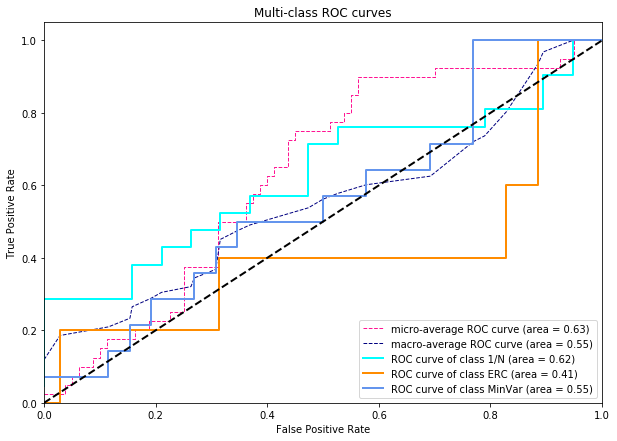

In [200]:
# Compute ROC curve and ROC area for each class

a = np.zeros(test_pred.shape,int)
b = np.argmax(p,axis=1)
b = b[:,None]
v = np.ones(test_pred.shape[0],int)
v = v[:,None]

np.put_along_axis(a, b, v, axis=1)

# w = np.std(p,axis=1)
# w = w / np.mean(w)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(a[:, i], test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(a.ravel(), test_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,7))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle='--', linewidth=1)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle='--', linewidth=1)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
classes = ['1/N','ERC','MinVar']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class ' + classes[i] + ' (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC curves')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_prob = classifier.predict_proba(X_train)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

## Test the FNN Model

Similar to training the nerual network, we also need to load batches of test images and collect the outputs. The differences are that:
(1) No loss & weights calculation
(2) No wights update
(3) Has correct prediction calculation

In [42]:
correct = 0
total = 0
for images, labels in test_loader:
    labels = labels.long()
    images = Variable(images)#.view(-1, 28*28))
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)  # Choose the best class from the output: The class with the best score
    total += labels.size(0)                    # Increment the total count
    correct += (predicted == labels).sum()     # Increment the correct count
    
print('Accuracy of the network on the 10K test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10K test images: 55 %


## Save the trained FNN Model for future use

In [11]:
# Save the model
#torch.save(net.state_dict(), 'fnn_model.pkl')